Clustering aisles by their hour-of-day signature
-------------------------------------------------------

This is a small exploration notebook about the [Instacart Kaggle Competition](https://www.kaggle.com/c/instacart-market-basket-analysis). I noticed [in their blog post](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2) that the people who prepared the data set found a set of products that are most often ordered early in the day, and another set that was ordered most often later in the day. I was wondering how they found them, and decided to try it out for myself. Here's how to do something similar using hierarchical clustering.

First we load up the data and transform it such that for each aisle (categories into which the products are divided, such as "fresh pasta") in the data set we get the number of orders at every hour of the day. (I tried clustering the products themselves first, but there are too many of them and no clear clustering emerged.)

In [8]:
import warnings; warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


# Data about all the orders apart from which
# products they contain
orders = pd.read_csv('input/orders.csv')

# The set of prior orders we want to use to
# predict the next order a user is going to place
orders_prior = orders[orders['eval_set'] == 'prior']

# Add the product information to the prior orders
products_prior = pd.read_csv('input/order_products__prior.csv')
products_prior = products_prior.merge(
    orders_prior, 
    how = 'left', 
    on = 'order_id'
)

# Add aisle data
products = pd.read_csv('input/products.csv')[['product_id', 'aisle_id']]
products_aisle = products_prior.merge(products, how='left', on = 'product_id')

# Group by aisle and hour of day and count
products_aisle_hod = products_aisle.groupby(['aisle_id','order_hour_of_day']).size()

# Unstack into 2D dataframe; missing values mean zero orders
hod_data = products_aisle_hod.unstack('order_hour_of_day').fillna(0)

# Normalize
hod_data = hod_data.div(hod_data.sum(axis=1), axis=0)
hod_data.head(3)

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
aisle_id,,,,,,,,,,,,,,,,,,,,,
1,0.005672,0.003684,0.002655,0.001543,0.002127,0.003406,0.009607,0.024427,0.050189,0.072656,...,0.081846,0.082944,0.082485,0.068026,0.052052,0.038066,0.026666,0.020979,0.016697,0.010955
2,0.007492,0.003673,0.002425,0.001685,0.001661,0.002364,0.007819,0.023615,0.046272,0.069983,...,0.083258,0.084239,0.080894,0.067971,0.052575,0.036380,0.029191,0.025591,0.019178,0.013650
3,0.005601,0.002848,0.001608,0.001212,0.001139,0.002239,0.008600,0.026237,0.057011,0.089733,...,0.081841,0.079862,0.075136,0.061135,0.046031,0.035143,0.027069,0.022266,0.017062,0.011184


Now we perform the clustering using `scipy`. As distance metric we use the correlation between the hour-of-day signatures. I've already truncated the dendrogram to what seems like a good level.

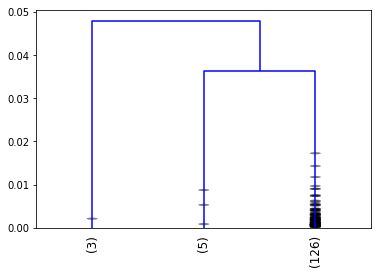

In [2]:
# Hierarchical clustering
Z = linkage(hod_data.values, 'average', 'correlation')
dendrogram(
    Z,
    truncate_mode='lastp',
    
    # It seems that 3 clusters gives a fairly
    # decent separation
    p=3,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True
)
plt.show()

We see we have three clusters, two small ones and one big one. Let's grab the cluster assigned to each of the aisles and look at their hour-of-day signatures to see if we've found anything interesting.

In [3]:
# Assign clusters to the aisles
hod_data['clust'] = fcluster(Z, 3, criterion='maxclust')
hod_data.groupby('clust').size()

clust
1      3
2      5
3    126
dtype: int64

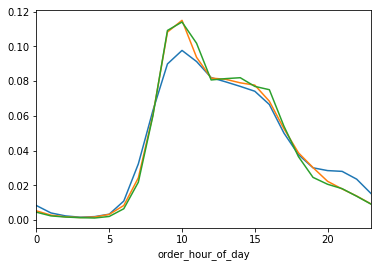

In [4]:
# First cluster: only three aisles, but they
# all peak early in the day
clust_1 = hod_data[hod_data['clust']==1]
clust_1.drop('clust', axis=1).T.plot(legend=False)
plt.show()

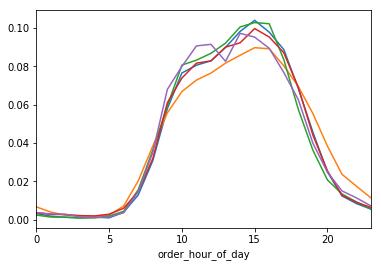

In [5]:
# Second cluster: only five aisles, all peaking
# later in the day
clust_2 = hod_data[hod_data['clust']==2]
clust_2.drop('clust', axis=1).T.plot(legend=False)
plt.show()

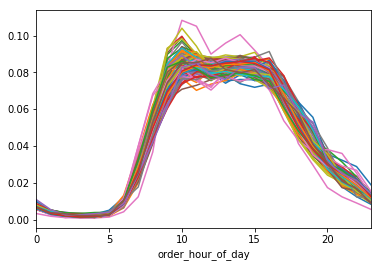

In [6]:
# The last cluster contains the bulk of the aisles,
# which mostly don't show any strong peakm apart
# from of course more orders during the day than
# at night.
clust_3 = hod_data[hod_data['clust']==3]
clust_3.drop('clust', axis=1).T.plot(legend=False)
plt.show()

Looks like we've found the two types of signatures we're looking for, although only a handful of aisles show this signature. The bulk of the aisles shows a flatter distribution. Let's take the average signal in each cluster and summarize our findings.

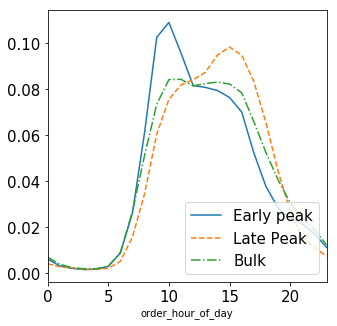

In [7]:
# Average the clusters
clust_1_avg = clust_1.drop('clust', axis=1).mean().to_frame()
clust_2_avg = clust_2.drop('clust', axis=1).mean().to_frame()
clust_3_avg = clust_3.drop('clust', axis=1).mean().to_frame()
cluster_avg = pd.concat([clust_1_avg, clust_2_avg, clust_3_avg], axis=1)
cluster_avg.columns = ['Early peak', 'Late Peak', 'Bulk']

# Plot
ax = cluster_avg.plot(style=['-','--','-.'], figsize=(5,5), fontsize = 15);
ax.legend(fontsize=15, loc='lower right')
plt.show()